In [4]:
# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# set the display properties
%matplotlib inline

# import modules and plot setting
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits
from mangatools import maps, utils

today = datetime.date.today().isoformat()

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# customize the warning message
import warnings
warnings.filterwarnings("ignore") # default or ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Spectrum Fitting Demonstration

## Testting for a single galaxy

In [ ]:
# single test

from mangatools.voronoi_2d_binning import voronoi_2d_binning
from mangatools.maps import Maps
from mangatools.datacube import Datacube
#warnings.filterwarnings("ignore")

plateifu = '8132-6101'
m = Maps(plateifu)
agn, cp, sf, *others = m.bptregion()
mask = ~(agn | cp | sf)
#mask = np.ones_like(agn)
#mask[23, 23] = 0
dc = Datacube(plateifu)
dc.flux_map(plateifu, mask=mask, directory='/tmp', quiet=1, auto=True)

In [ ]:
from astropy.io import fits
with fits.open('/tmp/{}.fits'.format(plateifu)) as f:
    #f.info()
    Ha= f['Halpha'].data[0]
    plt.imshow(Ha)

In [ ]:
# fitting with spectrum after stacking
with fits.open('/tmp/{}.fits'.format(plateifu)) as f:
    Hb = f['Hbeta'].data[0]
    Hb_err = f['Hbeta'].data[1]
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
                    m.ra_map.flatten(), m.dec_map.flatten(), Hb.flatten(), Hb_err.flatten()+1e-8, 
                    10, plot=0, quiet=1)
    #binNum = np.zeros_like(Hb.flatten())
    binNum = binNum.reshape(Hb.shape)

dc.stack(binNum)
dc.flux_map(plateifu+'_binned', mask=mask, directory='/tmp', quiet=1, auto=True)

In [ ]:
from astropy.io import fits
with fits.open('/tmp/{}_binned.fits'.format(plateifu)) as f:
    #f.info()
    Ha= f['Halpha'].data[0]
    plt.imshow(Ha)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
f = fits.open('/tmp/{}.fits'.format(plateifu))
im = ax[0].imshow(f['Hbeta'].data[0])
plt.colorbar(im, ax=ax[0])
f2 = fits.open('/tmp/{}_binned.fits'.format(plateifu))
im = ax[1].imshow(f2['Hbeta'].data[0])
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(binNum)
plt.colorbar(im, ax=ax[2])

## Statistics

In [ ]:
# Fitting all the datacubes of DR15

fitmaps_dir = '/Volumes/Lacie2/ENLR/fitmaps' #set to your local folder
fitmaps_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned' #set to your local folder

from vorbin.voronoi_2d_binning import voronoi_2d_binning
#warnings.filterwarnings("ignore")

targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')

for idx, plateifu in enumerate(targets['plateifu']):
    print(idx, plateifu)
    m = galaxy.Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    mask = agn | cp | sf
    #mask = np.ones_like(agn)
    #mask[23, 23] = 0
    dc = galaxy.Datacube(plateifu)
    dc.flux_map(plateifu, mask=~mask, directory=fitmaps_dir, quiet=1, auto=True)

    with fits.open(fitmaps_dir+'{}.fits'.format(plateifu)) as f:
        Hb = f['Hbeta'].data[0]
        Hb_err = f['Hbeta'].data[1]
        binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
                        m.ra_map.flatten(), m.dec_map.flatten(), Hb.flatten(), Hb_err.flatten()+1e-8, 
                        10, plot=0, quiet=1)
        #binNum = np.zeros_like(Hb.flatten())
        binNum = binNum.reshape(Hb.shape)

    dc.stack(binNum)
    dc.flux_map(plateifu, mask=~mask, directory=fitmaps_binned_dir, quiet=1, auto=True)

## Demo-Sample-Detail

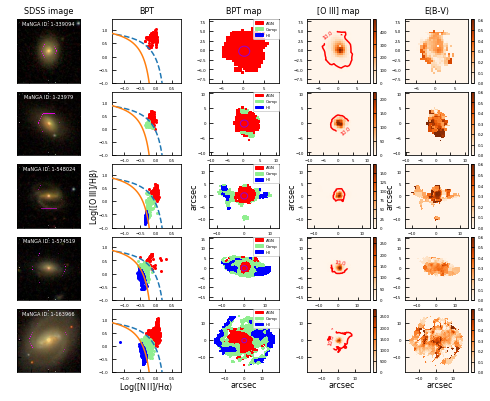

In [5]:
# Demo + Paper, pick some example for illustration of the paper
# History: 
#  2018-10-04: add history
#  2019-01-14: 

from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps

fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/' #set to your local folder

targets = ['8141-1901', '7991-3702', '8132-6101', '8725-9102', '8940-12702']

fig = plt.figure(figsize=(8, 7))
ax0 = fig.subplots(1, 5)
for i in range(5):
    ax0[i].spines['top'].set_color('none')
    ax0[i].spines['bottom'].set_color('none')
    ax0[i].spines['left'].set_color('none')
    ax0[i].spines['right'].set_color('none')
    ax0[i].tick_params(axis='both', labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=2)

ax = fig.subplots(5, 5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, wspace=0.4, hspace=0.14)

for i in range(len(targets)):
    plateifu = targets[i]
    try:
        m = Maps(plateifu)
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)

#plt.imshow(m2.E_BV, origin='lower')
    except:
        print('Escape plateifu:{}'.format(plateifu))
        continue
    m.image(ax=ax[i, 0], showImage=False, mini=True, fs=5)
    m.bpt(ax=ax[i, 1], showImage=False, mini=True, fs=4)
    m.bpt2d(ax=ax[i, 2], show_psf=True, showImage=False, mini=True, fs=4)
    #ax[i, 2].text(-5, 5, '19', fontsize=fs)
    #m.vfield(ax=ax[i, 2], showImage=False, mini=True, fs=2)
    #m.line('OIII-5008', plot=True, ax=ax[i, 3], showImage=False, redcorr=True, snr=3,
    #       mini=True, fs=4, showColorbar=False)
    #m.line_ew('Ha-6564', plot=True, ax=ax[i, 4], showImage=False, mini=True, fs=4, showColorbar=False)
    O3_corr, O3_corr_err = fm.O3map(fix_outlier=True, smooth=False)

    #m.redcorrmap(plot=True, showImage=False, ax=ax[i,4], mini=True, fs=4, showColorbar=True)
    x, y = m.maps['SPX_SKYCOO'].data
    x = np.flip(x)
    extent = [x.min(), x.max(), y.min(), y.max()]

    im = ax[i, 3].pcolormesh(x, y, 4 * O3_corr)
    cs = ax[i, 3].contour(x, y, 4 * O3_corr, levels=[10], colors='r', extent=extent)
    plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
    cbar = plt.colorbar(im, ax=ax[i, 3], fraction=0.056, pad=0.04)
    cbar.ax.tick_params(labelsize=4)
    ax[i, 3].tick_params(axis='both', which='major', labelsize=4)

    E_BV = fm.E_BV
    im = ax[i, 4].pcolormesh(x, y, E_BV, vmax=0.6)
    cbar = plt.colorbar(im, ax=ax[i, 4], fraction=0.056, pad=0.04)
    cbar.ax.tick_params(labelsize=4)
    ax[i, 4].tick_params(axis='both', which='major', labelsize=4)


ax[0, 0].set_title('SDSS image', fontsize=8)
ax[0, 1].set_title("BPT", fontsize=8)
ax[0, 2].set_title('BPT map', fontsize=8)
ax[0, 3].set_title('[O III] map', fontsize=8)
ax[0, 4].set_title("E(B-V)", fontsize=8)

ax0[1].set_ylabel(r'${\rm Log([O\,III]/H\beta)}$', fontsize=8)
ax0[1].set_xlabel(r'${\rm Log([N\,II]/H\alpha)}$', fontsize=8)
ax0[2].set_xlabel('arcsec', fontsize=8)
ax0[2].set_ylabel('arcsec', fontsize=8)
ax0[3].set_xlabel('arcsec', fontsize=8)
ax0[3].set_ylabel('arcsec', fontsize=8)
ax0[4].set_xlabel('arcsec', fontsize=8)
ax0[4].set_ylabel('arcsec', fontsize=8)


plt.show()
#plt.tight_layout()
fig.savefig("./results/detail_sample.pdf", bbox_inches='tight')

# [O III] Luminosity
Calculating the luminosity of [O III]5007Å and saving into data/LO3.dat

In [ ]:
# Measuring L[OIII5007], using fitting [O III] map
#
# History:
#   2018-08-24: first release
#   2018-09-06: update the error calculation
#   2019-01-12: using new OIII data

fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/' #set to your local folder

warnings.filterwarnings("ignore")
targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')

with open('data/LO3-{}.dat'.format(today), 'w') as f:
    f.write("# AGNs_file: data/AGNs-2018-12-24.dat\n")
    f.write("# Using datacube fitting map to calculate the L[O III] 5007\n")
    f.write("{} {} {} {} {} {} {} {} {}\n".format("plateifu", "LO3", "LO3_err_low", 
                                               "LO3_err_up","LO3_redcorr", "LO3_redcorr_err_low", 
                                               "LO3_redcorr_err_up", "outflow_strength", 
                                               "outflow_strength_err"))
    tot_num = len(targets[:])
    for i in range(tot_num):
        plateifu = targets['plateifu'][i]
        m = Maps(plateifu)
        #m2 = Maps2(plateifu)
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
        
        O3_narrow, O3_narrow_err = fm.line('[OIII]5008')[0], fm.line('[OIII]5008')[1]
        O3_broad, O3_broad_err = fm.line('_[OIII]5008')[0], fm.line('_[OIII]5008')[1]
        O3_corr, O3_corr_err = fm.O3map()
        agn, cp, *others = m.bptregion()
        
        O3_narrow_sum, O3_narrow_sum_err = np.sum(O3_narrow[agn]), np.sqrt(np.sum(O3_narrow_err[agn]**2))
        O3_broad_sum, O3_broad_sum_err = np.sum(O3_broad[agn]), np.sqrt(np.sum(O3_broad_err[agn]**2))
        
        outflow_strength = O3_broad_sum / (O3_narrow_sum + O3_broad_sum)
        outflow_strength_err = np.sqrt((O3_broad_sum_err/O3_narrow_sum)**2 +
                                       (O3_narrow_sum_err/O3_narrow_sum**2*O3_broad_sum)**2)
        #outflow_strength = np.sum(O3_broad[agn]) / np.sum(O3_narrow[agn])
        #outflow_strength_err = np.sqrt(np.sum((O3_broad_err[agn]/O3_narrow[agn])**2) 
        #               + np.sum((O3_narrow_err[agn]/(O3_narrow[agn])**2 * O3_broad[agn])**2))
        
        O3_agn = np.sum(O3_narrow[agn] + O3_broad[agn])
        O3_agn_up = np.sum(O3_narrow[agn|cp] + O3_broad[agn|cp])
        O3_agn_err = np.sqrt(np.sum(O3_narrow_err[agn]**2 + O3_broad_err[agn]**2))
        O3_agn_err_up = np.sqrt(np.sum(O3_narrow_err[agn|cp]**2 + O3_broad_err[agn|cp]**2))
    
        O3_agn_corr = np.sum(O3_corr[agn])
        O3_agn_corr_up = np.sum(np.sqrt(O3_corr[agn|cp]**2))
        O3_agn_corr_err = np.sum(np.sqrt(O3_corr_err[agn]**2))
        O3_agn_corr_err_up = np.sum(np.sqrt(O3_corr_err[agn|cp]**2))
        
        LO3 = np.log10(O3_agn*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))
        #LO3_err_low = np.log10(O3_agn_err*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3
        LO3_err_low = O3_agn_err/np.log(10)/O3_agn
        #LO3_err_up = np.log10(O3_agn_err_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3
        LO3_err_up = O3_agn_err_up/np.log(10)/O3_agn
        LO3_redcorr = np.log10(O3_agn_corr*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))
        #LO3_redcorr_err_low = np.log10(O3_agn_corr_err*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3_redcorr
        LO3_redcorr_err_low = O3_agn_corr_err/np.log(10)/O3_agn_corr
        #LO3_redcorr_err_up = np.log10(O3_agn_corr_err_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3_redcorr
        LO3_redcorr_err_up = O3_agn_corr_err_up/np.log(10)/O3_agn_corr_err_up
        f.write("{} {} {} {} {} {} {} {} {}\n".format(plateifu, LO3, LO3_err_low, LO3_err_up, 
                                                   LO3_redcorr, LO3_redcorr_err_low,
                                                   LO3_redcorr_err_up, outflow_strength,
                                                   outflow_strength_err))
        utils.processBar(tot_num-1, i)
    print('Done! Write into {}'.format(f.name))

# Shapes of ENLR

Different morphology of ENLR
Using the Fourier series to determine it's shape, by calculate the agn fraction in every derection, and fitting it with Forier series, the different components of the fourier series stands for different period shape.(He Z. C. 2018 in prepare)
$$f(\theta_k) = a_0 + \sum^\infty_{m=1}[a_m\cos(m\theta_k+b_m\sin(m \theta_k)] $$
We divided the circle 360 degree into 36 bins, each with 10 degree, so the discret series with the parameter of each component is:
$$ a_m = \frac{2}{2\pi}\sum^{36}_{k=1}f(\theta)\cos(m\theta_k)\frac{10\pi}{180} $$
$$ b_m = \frac{2}{2\pi}\sum^{36}_{k=1}f(\theta)\sin(m\theta_k)\frac{10\pi}{180} $$
$$ a_0 = \frac{1}{36}\sum^{36}_{k=1}f(\theta) $$

## Demo-ENLR-Shapes

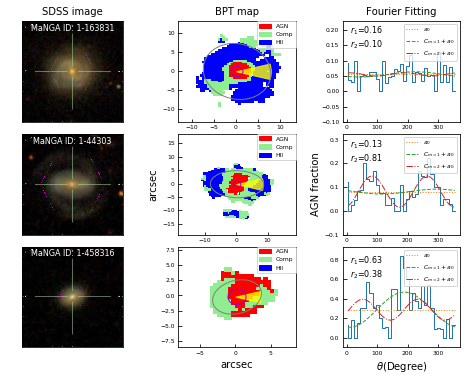

In [6]:
# demo used in the papaer
# History:
#   2018-10-23: update for PPT

set_matplotlib_formats('png')

from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection

targets = ['8147-6102', '8718-12701', '9881-1901']
fs = 10

fig = plt.figure(figsize=(8, 6))
ax0 = fig.subplots(1, 3)
for i in range(3):
    ax0[i].spines['top'].set_color(None)
    ax0[i].spines['bottom'].set_color(None)
    ax0[i].spines['left'].set_color(None)
    ax0[i].spines['right'].set_color(None)
    ax0[i].tick_params(axis='both', labelcolor='w', top=False, bottom=False, left=False, right=False, labelsize=2)
    

ax = fig.subplots(3,3)
plt.subplots_adjust(wspace=0.4, hspace=0.12)
for i in range(len(targets)):
    plateifu = targets[i]
    m = Maps(plateifu)
    m.image(ax=ax[i,0], mini=True, showImage=False)
    m.bpt2d(ax=ax[i,1], mini=True, showImage=False, show_psf=True, show_Re=True, Re=2.5,
            fs=6, showTitle=False)
    r1, r2 = m.eshape(plot=True, ax=ax[i,2], fs=fs-4, lw=1, ms=2)
    ax[i, 1].set_xlabel("")
    ax[i, 2].set_xlabel("")
    ax[i, 2].set_ylabel("")
    # add the sectors
    patches = [Wedge((0., -0.2), 2.5*m.elpetro_r/2, -15, 15),]
    p = PatchCollection(patches, alpha=0.8, color='yellow')
    #colors = 100*np.random.rand(len(patches))
    #p.set_array()
    ax[i, 1].add_collection(p)
    
ax[0, 0].set_title('SDSS image', fontsize=fs)
ax[0, 1].set_title('BPT map', fontsize=fs)
ax[0, 2].set_title('Fourier Fitting', fontsize=fs)
ax[2, 1].set_xlabel('arcsec', fontsize=fs)
ax[1, 1].set_ylabel('arcsec', fontsize=fs)
ax[2, 2].set_xlabel(r'$\theta$(Degree)', fontsize=fs)
ax[1, 2].set_ylabel('AGN fraction', fontsize=fs)
  
fig.savefig('./results/morphology_exmaple.pdf', bbox_inches='tight')
plt.show()
set_matplotlib_formats('png')